# REINFORCE algorithm

In [10]:
import numpy as np
import gym
from gym import spaces

class InventoryEnv(gym.Env):
    def __init__(self, min_inv=-10, max_inv=10):
        super().__init__()
        self.min_inv = min_inv
        self.max_inv = max_inv
        self.action_space = spaces.Discrete(3)  # three ordering levels
        # Observation: [inventory_level, time_step]
        self.observation_space = spaces.Box(
            low=np.array([min_inv, 0]), high=np.array([max_inv, float('inf')]), dtype=np.float32
        )
        self.p, self.a_cost, self.b_cost = 1, 1, 2
        self.reset()

    def reset(self):
        self.s = 0
        self.t = 0
        return np.array([self.s, self.t], dtype=np.float32)

    def step(self, action):
        # Map discrete action to order quantity (e.g., [0,1,2] → [0, 5, 10])
        a = action * 5
        w = np.random.randint(0, 11)
        s_next = self.s + a - w
        # Clip inventory to bounds
        self.s = np.clip(s_next, self.min_inv, self.max_inv)
        self.t += 1
        # Compute cost and convert to reward
        cost = self.p * a + (self.a_cost * s_next if s_next >= 0 else self.b_cost * -s_next)
        reward = -cost
        done = (self.t >= 100)
        obs = np.array([self.s, self.t], dtype=np.float32)
        return obs, reward, done, {}


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, num_actions):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=-1)


In [12]:
import torch.optim as optim
import matplotlib.pyplot as plt

def reinforce(env, policy, num_episodes=500, gamma=1.0, lr=1e-3, log_interval=50):
    optimizer = optim.Adam(policy.parameters(), lr=lr)
    episode_rewards = []              # <-- list to store total reward per episode

    for episode in range(1, num_episodes + 1):
        log_probs, rewards = [], []
        state = env.reset()
        done = False

        # Generate one episode
        while not done:
            state_tensor = torch.from_numpy(state).float().unsqueeze(0)
            probs = policy(state_tensor)
            dist = torch.distributions.Categorical(probs)
            action = dist.sample()
            log_probs.append(dist.log_prob(action))
            next_state, reward, done, _ = env.step(action.item())
            rewards.append(reward)
            state = next_state

        total_reward = sum(rewards)
        episode_rewards.append(total_reward)    # <-- record it

        # compute returns and update policy (same as before) …
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        loss = torch.stack([-lp * G for lp, G in zip(log_probs, returns)]).sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if episode % log_interval == 0:
            print(f"Episode {episode}/{num_episodes}, total reward: {total_reward:.2f}")

    # After all episodes, plot the learning curve
    plt.figure()
    plt.plot(range(1, num_episodes + 1), episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('REINFORCE Learning Curve')
    plt.grid(True)
    plt.show()

    return episode_rewards  # in case you want to save or analyze them further

Episode 50/500, total reward: -2828.00
Episode 100/500, total reward: -3033.00
Episode 150/500, total reward: -2977.00
Episode 200/500, total reward: -2819.00
Episode 250/500, total reward: -1453.00
Episode 300/500, total reward: -1544.00
Episode 350/500, total reward: -1742.00
Episode 400/500, total reward: -1506.00
Episode 450/500, total reward: -1560.00
Episode 500/500, total reward: -1172.00


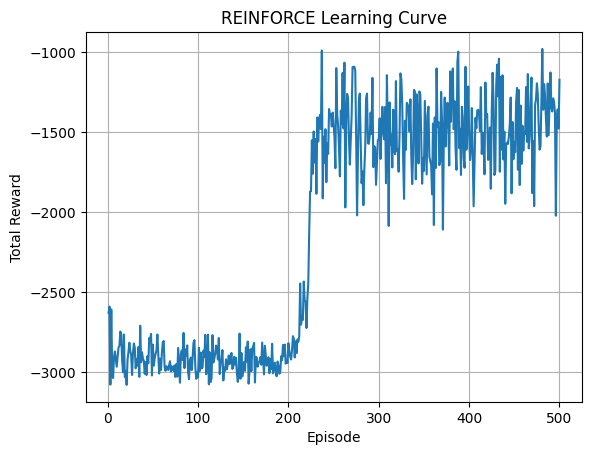

In [13]:
if __name__ == "__main__":
    env = InventoryEnv(min_inv=-10, max_inv=10)
    state_dim = env.observation_space.shape[0]
    num_actions = env.action_space.n
    policy = PolicyNetwork(state_dim, num_actions)
    reinforce(env, policy, num_episodes=500, gamma=1.0, lr=1e-3)


Episode 50/500, total reward: -2613.00
Episode 100/500, total reward: -2864.00
Episode 150/500, total reward: -2764.00
Episode 200/500, total reward: -2488.00
Episode 250/500, total reward: -2502.00
Episode 300/500, total reward: -2385.00
Episode 350/500, total reward: -2407.00
Episode 400/500, total reward: -2471.00
Episode 450/500, total reward: -2518.00
Episode 500/500, total reward: -2539.00


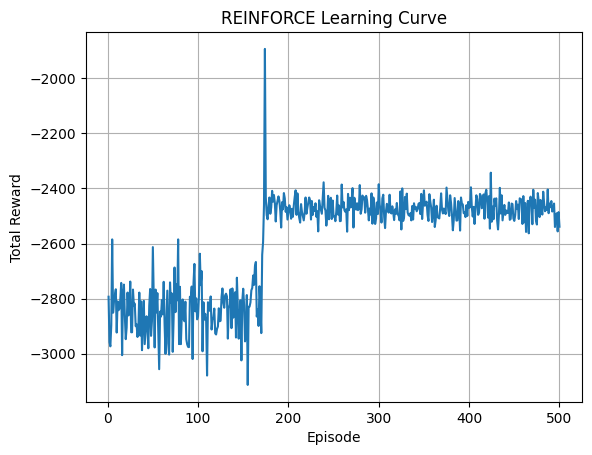

In [14]:
if __name__ == "__main__":
    env = InventoryEnv(min_inv=-10, max_inv=10)
    policy = PolicyNetwork(state_dim=2, num_actions=3)
    rewards = reinforce(env, policy, num_episodes=500, gamma=1.0, lr=1e-3)
